In [1]:
import os
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as clrs

## 0. Functions

In [2]:
def load_data(root: str, true_dir: str, false_dir: str):
    labels = [(True, true_dir), (False, false_dir)]
    dfs = []

    for label, sub_dir in labels:
        sub_root = os.path.join(root, sub_dir)
        patient_ids = os.listdir(sub_root)

        for patient_id in patient_ids:
            patient_path = os.path.join(sub_root, patient_id, "stats.csv")
            df = pd.read_csv(patient_path)
            
            df["patient_id"] = patient_id
            df["Sjogren"] = label

            dfs.append(df)
    
    df = pd.concat(dfs).reset_index().drop(["Unnamed: 0", "index"], axis=1)

    # Fill missing MD values with the mean
    mean_value = df['mean MD'].mean()
    df['mean MD'].fillna(value=mean_value, inplace=True)

    return df

In [15]:
def compute_corr(data: pd.DataFrame, metric: str):
    metric_data = data.pivot(index="patient_id", columns="bundle", values=metric).reset_index()
    label = data.groupby(["patient_id"]).mean().reset_index()[["patient_id", "Sjogren"]]

    corrs = metric_data.merge(label).corr()["Sjogren"].drop("Sjogren")
    idx = corrs.abs().sort_values(ascending=False).index
    
    return corrs[idx]

def compute_ttest(data: pd.DataFrame, metric: str):
    data = data[["bundle", metric, "Sjogren"]]

    bundles_ttest = [
        ttest_ind(
            data[(data["bundle"] == bundle) & (data["Sjogren"] == True)][metric],
            data[(data["bundle"] == bundle) & (data["Sjogren"] == False)][metric],
        ).pvalue for bundle in pd.unique(data["bundle"])
    ]
    
    return pd.Series(bundles_ttest, index=pd.unique(data["bundle"]))

def plot_metric(data: pd.DataFrame, metric: str, top: int = 20):
    sns.set_theme()
    fig, axes = plt.subplots(1, 3, figsize=(20, 15), gridspec_kw={'width_ratios': [4, 1, 0.75]})
    fig.suptitle(
        f"Analysis of '{metric}' in the bundles between patient with Sjogren and without (top {top} correlating bundles)", 
        y=0.92
    )

    corrs = compute_corr(data, metric).head(top)
    ttest = compute_ttest(data, metric).loc[corrs.index]

    sns.boxplot(data=data, y="bundle", x=metric, hue="Sjogren", order=corrs.index, ax=axes[0])
    axes[0].set_title(f"Distribution of '{metric}' in the bundles")  
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.5))
    axes[0].yaxis.grid(True, which='minor', color='white', lw=2)

    sns.heatmap(corrs.to_numpy()[..., None], annot=True, linewidths=1, linecolor='black', clip_on=False, ax=axes[1])
    axes[1].set_title("Pearson correlation")  
    axes[1].set(xticklabels=[])
    axes[1].set(yticklabels=[])

    sns.heatmap(
        ttest.to_numpy()[..., None], 
        annot=True, 
        linewidths=1, 
        linecolor='black', 
        clip_on=False, 
        cmap=clrs.ListedColormap(['#005600', '#700000']), 
        vmin=0.04, 
        vmax=0.06, 
        cbar=False, 
        ax=axes[2]
    )
    axes[2].set_title("P-value of the t-Test")  
    axes[2].set(xticklabels=[])
    axes[2].set(yticklabels=[])

    plt.savefig(f"tracto-corr-{metric}.jpg", transparent=False)

## 1. Loading data

In [4]:
data = load_data(
    "data",
    "Sjogren_DICOM_grupa_badana",
    "Sjogren_DICOM_grupa_kontrolna"
)

## 2. Analysis

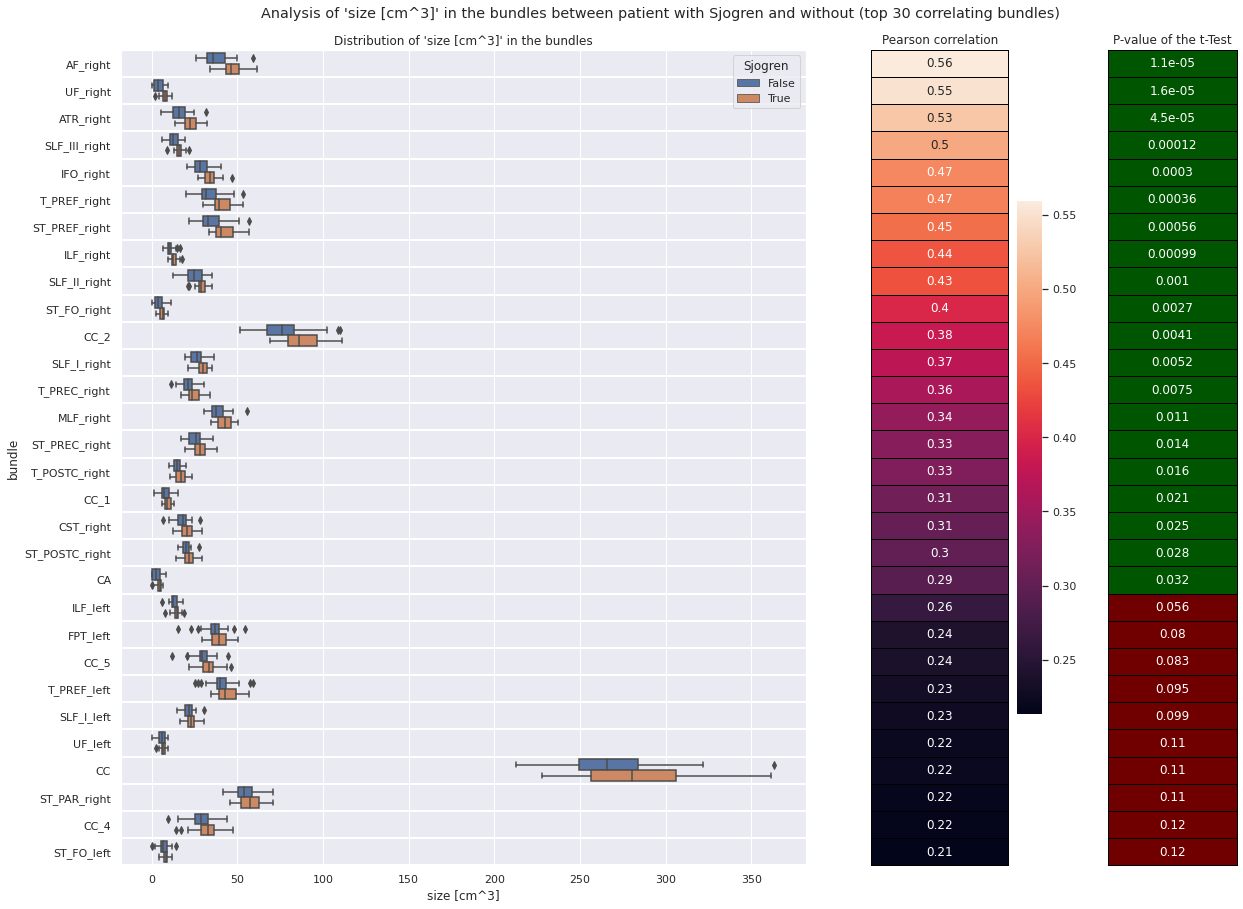

In [16]:
plot_metric(data, "size [cm^3]", top=30)

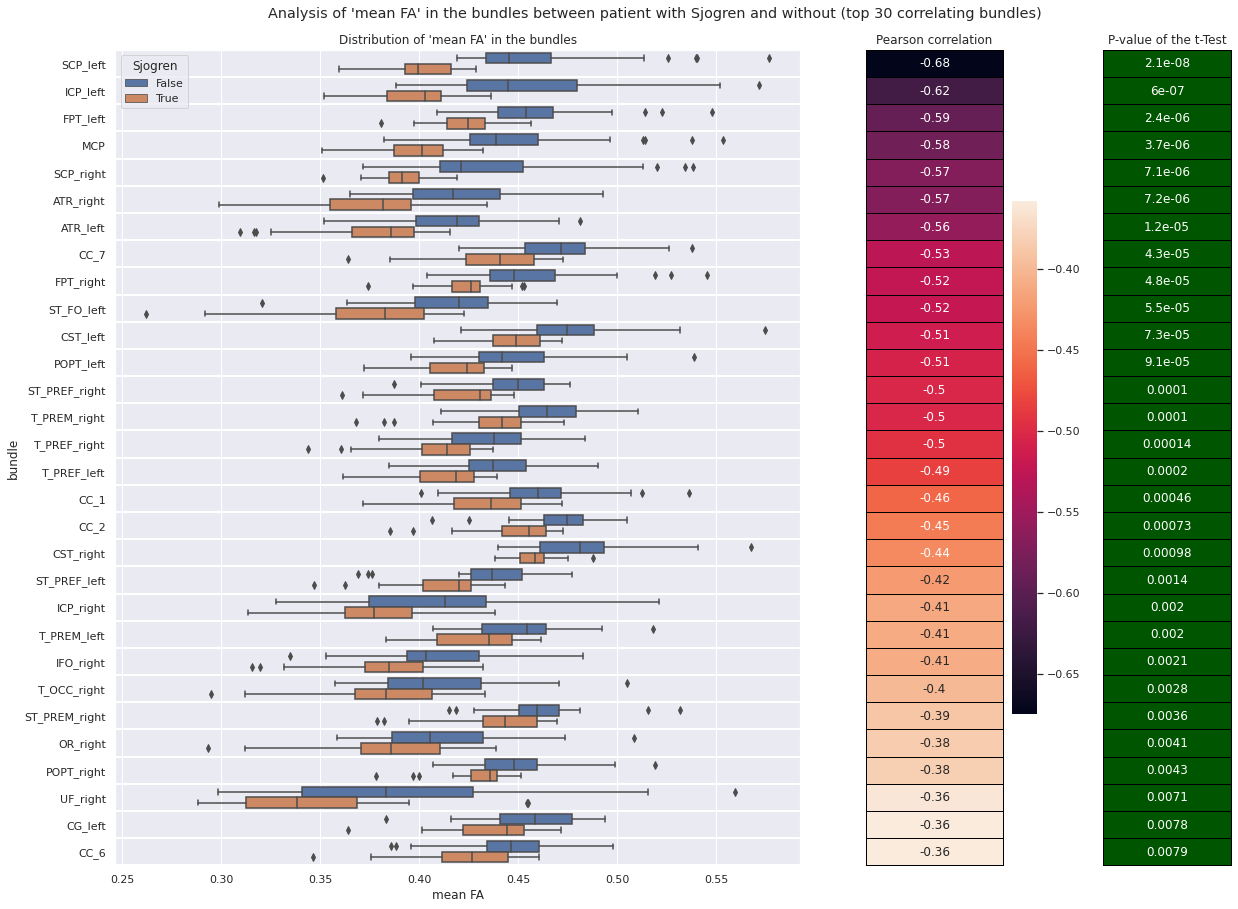

In [17]:
plot_metric(data, "mean FA", top=30)

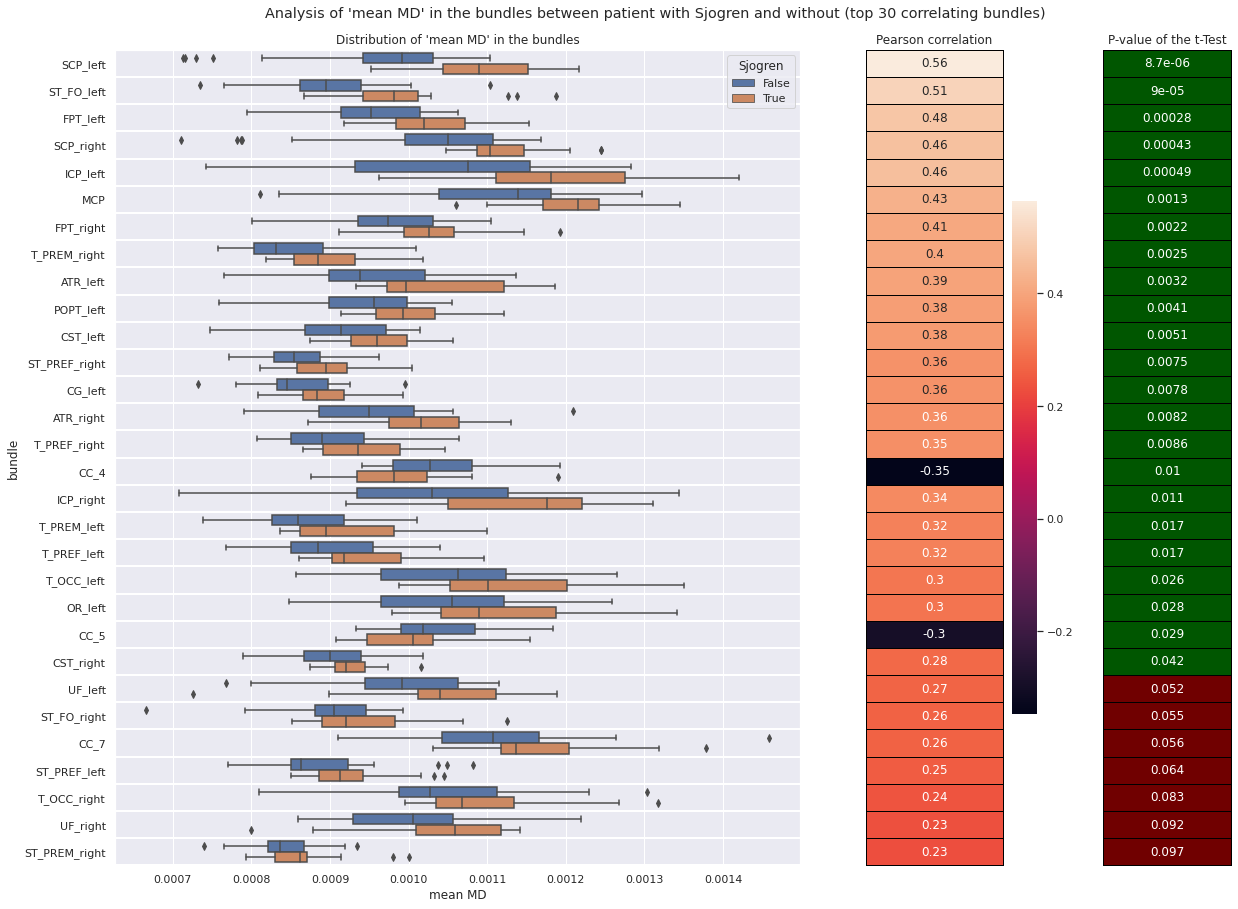

In [18]:
plot_metric(data, "mean MD", top=30)